In [1]:
from utils.imports import *

Using TensorFlow backend.


In [2]:
csv_path = PATH['annotations_train']
test_csv_path = PATH['annotations_test']

In [3]:
train_pred = pd.read_csv(csv_path + "0final.csv")
test_pred = pd.read_csv(test_csv_path + "0final.csv")

In [4]:
train_true = train_pred[train_pred['True']==1]
train_false = train_pred[train_pred['True']==0]
train_false = train_false[train_false.index%4 == 0]

In [5]:
train_pred = pd.concat([train_true,train_false],axis=0)

In [6]:
train_pred = train_pred.drop(['seriesuid','coordX','coordY','coordZ','file'],axis=1)

In [7]:
train = train_pred[['diameter_mm','probability_30_30_30_cube','probability_06_20_20','probability_10_30_30','probability_26_40_40','True']]
test = test_pred[['diameter_mm','probability_30_30_30_cube','probability_06_20_20','probability_10_30_30','probability_26_40_40']]
sample = test_pred[['seriesuid','coordX','coordY','coordZ']]

In [8]:
features = list(train.columns[1:-1])  #la colonne 0 est le quote_conversionflag  

In [9]:
xgb_model = xgb.XGBClassifier()

#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.5], #so called `eta` value
              'max_depth': [21],
              'min_child_weight': [13],
              'silent': [1],
              'subsample': [1],
              'n_estimators': [2000], #number of trees, change it to 1000 for better results
              #'missing':[-999],
              'seed': [1337]}


clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=StratifiedKFold(train['True'], n_folds=5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=1, refit=True)

clf.fit(train[features], train["True"])

#trust your CV!
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

test_probs = clf.predict_proba(test[features])[:,1]

#sample = pd.read_csv('../input/sample_submission.csv')
sample['probability'] = test_probs
#sample.to_csv("xgboost_best_parameter_submission.csv", index=False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.8s finished


('Raw AUC score:', 0.5466228606744479)
learning_rate: 0.5
max_depth: 21
min_child_weight: 13
n_estimators: 2000
nthread: 4
objective: 'binary:logistic'
seed: 1337
silent: 1
subsample: 1


In [10]:
test_probs.shape

(11199,)

In [11]:
aa = clf.predict_proba(test[features])

([array([ 3327.,  1059.,   730.,   656.,   571.,   551.,   592.,   678.,
           916.,  2119.]),
  array([ 2119.,   916.,   678.,   592.,   551.,   571.,   656.,   730.,
          1059.,  3327.])],
 array([  1.63316727e-05,   1.00013065e-01,   2.00009799e-01,
          3.00006533e-01,   4.00003266e-01,   5.00000000e-01,
          5.99996734e-01,   6.99993467e-01,   7.99990201e-01,
          8.99986935e-01,   9.99983668e-01]),
 <a list of 2 Lists of Patches objects>)

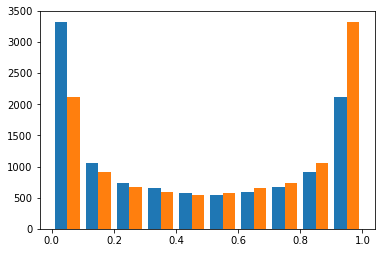

In [12]:
%matplotlib inline
plt.hist(aa,bins = 10)

(array([ 9983.,   223.,   127.,    74.,    63.,    67.,    62.,    76.,
          124.,   400.]),
 array([ 0.005,  0.104,  0.203,  0.302,  0.401,  0.5  ,  0.599,  0.698,
         0.797,  0.896,  0.995]),
 <a list of 10 Patch objects>)

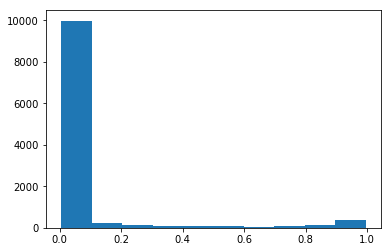

In [16]:
plt.hist(test_pred['probability_30_30_30_cube'],bins = 10)

In [17]:
sample

,seriesuid,coordX,coordY,coordZ,probability
0,LKDS-01004,-30.292711,-134.998786,12.162719,0.760224
1,LKDS-01004,-79.896122,5.639107,20.399999,0.863198
2,LKDS-01004,-183.468330,-168.430704,42.185278,0.569609
3,LKDS-01004,42.481598,-140.302859,62.933097,0.143778
4,LKDS-01004,-64.684913,-129.913196,53.464393,0.905812
5,LKDS-01004,-40.828513,-153.831798,55.230468,0.067068
6,LKDS-01004,197.393584,-148.941298,56.999999,0.886458
7,LKDS-01004,49.014468,-163.072749,61.019757,0.898780
8,LKDS-01004,-37.717700,-169.590000,66.523912,0.929270
9,LKDS-01004,-67.026760,-143.632532,60.752082,0.878198
